# LSTM model to work on Fullname

In [6]:
!pip install fastprogress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
import string
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from fastprogress import master_bar, progress_bar

from sklearn.feature_extraction.text import CountVectorizer

## Data preprocessing

In [3]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_train.csv.gz")
val_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_val.csv.gz")
test_df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_2022_FullName_test.csv.gz")

In [4]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(7214894, 9)
(901862, 9)
(901862, 9)


In [11]:
train_df.head()

,full_name,asian,hispanic,nh_black,nh_white,other,total_n,race,race_code
0,Veit Karen,0.0,0.0,0.0,1.0,0.0,2.0,nh_white,3
1,Barahona Octavio,0.0,1.0,0.0,0.0,0.0,1.0,hispanic,1
2,Albert Jurieal,0.0,0.0,1.0,0.0,0.0,1.0,nh_black,2
3,Foco Kevin,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3
4,Ewen Deborah,0.0,0.0,0.0,1.0,0.0,1.0,nh_white,3


## Creating Vocab

In [9]:
vectorizer = CountVectorizer(analyzer='char', lowercase=False)

In [10]:
vectorizer.fit_transform(train_df['full_name'])

<7214894x55 sparse matrix of type '<class 'numpy.int64'>'
	with 79471282 stored elements in Compressed Sparse Row format>

In [14]:
vocab = list(vectorizer.get_feature_names_out())

In [16]:
n_letters = len(vocab)

## Creating Dataset

In [21]:
race_id_df = train_df[['race', 'race_code']].drop_duplicates().sort_values('race_code')
race_to_id = dict(race_id_df.values)
id_to_race = dict(race_id_df[['race_code', 'race']].values)
all_categories = list(id_to_race.values())
n_categories = len(all_categories)
seq_len = train_df['full_name'].str.len().max()

In [22]:
print(f"classes - {all_categories}")
print(f"no of classes - {n_categories}")
print(f"max seq len - {seq_len}")

classes - ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
no of classes - 5
max seq len - 47


In [31]:
# helper methods used for transform in dataset

all_letters = ''.join(vocab)
oob = n_letters + 1

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.ones(seq_len) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [32]:
lineToTensor('Jason')

tensor([12., 29., 47., 43., 42., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])

In [33]:
print(lineToTensor('Jason').size())

torch.Size([47])


In [41]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, train_df.columns.get_loc('full_name')]
    if self.transform:
      name = self.transform(name)
    label = self.df.iloc[idx, train_df.columns.get_loc('race_code')]
    #target = getTarget(label)
    target = torch.tensor(label, dtype=torch.int64)
    return name, target

In [42]:
train_dataset = EthniColorDataset(train_df, lineToTensor)
val_dataset = EthniColorDataset(val_df, lineToTensor)
test_dataset = EthniColorDataset(test_df, lineToTensor)

In [43]:
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([24., 33., 37., 48.,  0., 13., 29., 46., 33., 42., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(3)
1 tensor([ 4., 29., 46., 29., 36., 43., 42., 29.,  0., 17., 31., 48., 29., 50.,
        37., 43., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(1)
2 tensor([ 3., 40., 30., 33., 46., 48.,  0., 12., 49., 46., 37., 33., 29., 40.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(2)


In [50]:
num_workers = !lscpu | grep "^CPU(s):" | awk '{print $2}'

In [55]:
# The Dataset retrieves our dataset’s features and labels one sample at a time.
# While training a model, we typically want to pass samples in “minibatches”,
# reshuffle the data at every epoch to reduce model overfitting, and
# use Python’s multiprocessing to speed up data retrieval.

batch_size=128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [56]:
next(iter(train_dataloader))

[tensor([[24., 29., 40.,  ..., 56., 56., 56.],
         [18., 43., 31.,  ..., 56., 56., 56.],
         [ 9., 46., 37.,  ..., 56., 56., 56.],
         ...,
         [13., 29., 46.,  ..., 56., 56., 56.],
         [ 6., 29., 40.,  ..., 56., 56., 56.],
         [21., 37., 40.,  ..., 56., 56., 56.]]),
 tensor([3, 1, 3, 2, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 1, 2, 1, 1, 3,
         3, 3, 2, 3, 3, 1, 3, 2, 1, 0, 3, 1, 1, 3, 3, 3, 2, 3, 3, 3, 1, 4, 4, 3,
         2, 2, 3, 3, 3, 1, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3, 4,
         3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 1, 2, 3, 3, 0, 2, 3, 3, 2, 1,
         3, 3, 1, 2, 1, 3, 1, 3, 3, 3, 2, 4, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         2, 3, 3, 3, 3, 3, 3, 2])]

In [57]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())
    if i_batch == 2:
        break

0 torch.Size([128, 47]) torch.Size([128])
1 torch.Size([128, 47]) torch.Size([128])
2 torch.Size([128, 47]) torch.Size([128])


## Define LSTM Model

In [59]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = seq_len
vocab_size = n_letters + 1 + 1 # vocab + oob + 1

rnn = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
rnn.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Verify with sample data

In [65]:
input = lineToTensor('Rogers Renee')

print(input)
print("input shape : ",input.shape)
print("input shape w batch : ", input.unsqueeze(0).shape)
#print(hidden.shape)

# sending with batch 1
output = rnn(input.unsqueeze(0).to(device))
# print(output) - has 47x8 log values
print(output.shape)
print(output)
print(torch.argmax(output))
print(f"model predicted w/o train - {all_categories[torch.argmax(output).item()]}")

tensor([20., 43., 35., 33., 46., 47.,  0., 20., 33., 42., 33., 33., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
input shape :  torch.Size([47])
input shape w batch :  torch.Size([1, 47])
torch.Size([1, 5])
tensor([[-1.6279, -1.6090, -1.6168, -1.5790, -1.6152]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor(3, device='cuda:0')
model predicted w/o train - nh_white


## Training


In [66]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

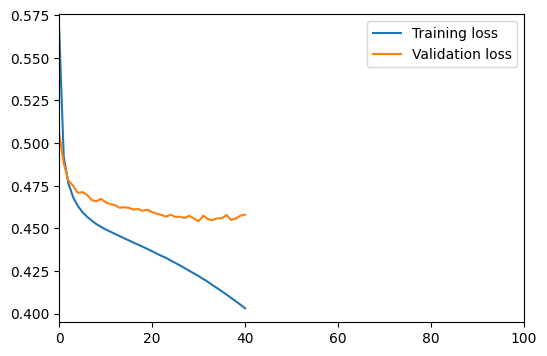

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 0.506261).  Saving model ...


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (0.506261 --> 0.488012).  Saving model ...
Validation loss decreased (0.488012 --> 0.478004).  Saving model ...
Validation loss decreased (0.478004 --> 0.475072).  Saving model ...
Validation loss decreased (0.475072 --> 0.470858).  Saving model ...
Validation loss decreased (0.470858 --> 0.469685).  Saving model ...
Validation loss decreased (0.469685 --> 0.466651).  Saving model ...
Validation loss decreased (0.466651 --> 0.465881).  Saving model ...
Validation loss decreased (0.465881 --> 0.465318).  Saving model ...
Validation loss decreased (0.465318 --> 0.464154).  Saving model ...
Validation loss decreased (0.464154 --> 0.463602).  Saving model ...
Validation loss decreased (0.463602 --> 0.462078).  Saving model ...
Validation loss decreased (0.462078 --> 0.462036).  Saving model ...
Validation loss decreased (0.462036 --> 0.461024).  Saving model ...
Validation loss decreased (0.461024 --> 0.460302).  Saving model ...
Validation loss decreased (0.46030

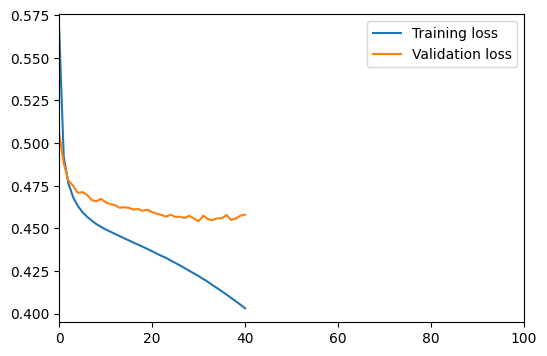

In [67]:
epochs = 100
lr = 0.0005 # 0.005 is very slow


# CrossEntropyLoss expects raw prediction values while NLLLoss expects log probabilities.
# criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
# since we are using nn.LogSoftmax as final layer at model
criterion = nn.NLLLoss()

optimizer = AdamW(rnn.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-5)


early_stopper = EarlyStopper(patience=10)


mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 1000

for epoch in mb:
  x.append(epoch)
  # Train
  i = 0
  rnn.train()
  total_loss = torch.Tensor([0.0]).to(device)
  for batch in progress_bar(train_dataloader, parent=mb):
    rnn.zero_grad()
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    # backward propagation
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    #torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()
    with torch.no_grad():
      total_loss += loss.item()
    i += 1
    #if i == till_batch:
    #  break

  # decay lr
  scheduler.step()

  mean = total_loss / len(train_dataloader)
  #mean = total_loss / till_batch
  training_losses.append(mean.cpu())

  # Evaluate
  i = 0
  rnn.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_dataloader, parent=mb):
      input = batch[0].to(device)
      label = batch[1].to(device)
      output = rnn(input)
      loss = criterion(output, label)
      validation_loss += loss.item()
      i += 1
      #if i == till_batch:
      #  break

  val_mean = validation_loss / len(val_dataloader)
  #val_mean = validation_loss / till_batch
  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(rnn.state_dict(), 'simple_rnn_ethni.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):
      break

## Save Model

In [68]:
torch.save(rnn.state_dict(), 'lstm_FullName_pytorch.pt')

Text(0, 0.5, 'loss')

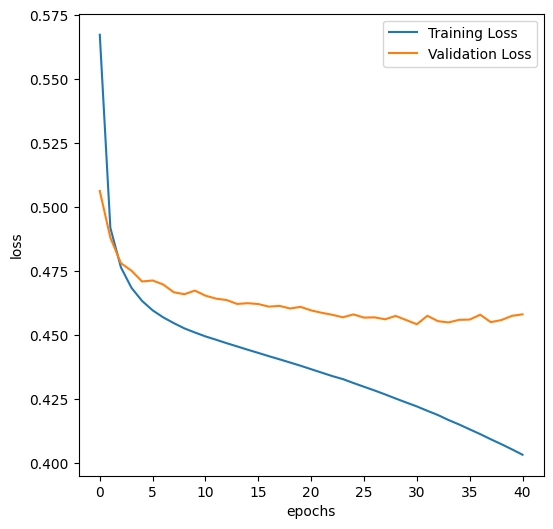

In [69]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, training_losses, validation_losses)
ax.legend(['Training Loss', 'Validation Loss'])
plt.xlabel("epochs")
plt.ylabel("loss")

In [70]:
# last epoch losses
print(training_losses[-1])
print(validation_losses[-1])

tensor([0.4031])
tensor([0.4580])


## Testing

In [71]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [72]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

Testing: 100%|██████████| 7045/7045 [02:06<00:00, 55.77it/s]


              precision    recall  f1-score   support

       asian       0.65      0.63      0.64     25754
    hispanic       0.85      0.86      0.85    163509
    nh_black       0.78      0.75      0.76    133457
    nh_white       0.89      0.93      0.91    552672
       other       0.40      0.07      0.12     26368

    accuracy                           0.85    901760
   macro avg       0.71      0.65      0.66    901760
weighted avg       0.84      0.85      0.84    901760



In [73]:
test_loss/len(test_dataloader)

0.46043037150962035

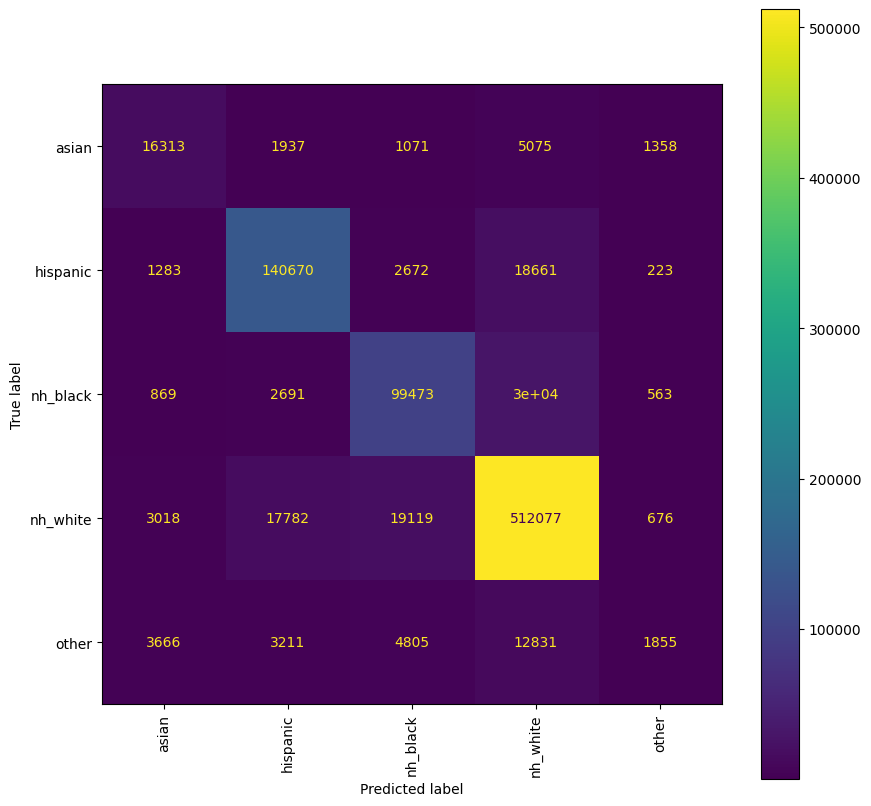

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [75]:
# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.460430

Test Accuracy of asian: 63% (16313/25754)
Test Accuracy of hispanic: 86% (140670/163509)
Test Accuracy of nh_black: 74% (99473/133457)
Test Accuracy of nh_white: 92% (512077/552672)
Test Accuracy of other:  7% (1855/26368)

Test Accuracy (Overall): 85% (770388/901760)


## Inference

In [76]:
name = "Ward Stephanie"
name_tokens = lineToTensor(name)
inp = name_tokens
print(inp.shape)
out = rnn(inp.unsqueeze(0).to(device))
print(out.shape)
out = torch.argmax(out)
print(out)
print(all_categories[out.item()])

torch.Size([47])
torch.Size([1, 5])
tensor(3, device='cuda:0')
nh_white


## Load and Test

In [77]:
test_rnn = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
test_rnn.load_state_dict(torch.load('lstm_FullName_pytorch.pt'))
test_rnn.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

Testing: 100%|██████████| 7045/7045 [02:05<00:00, 56.18it/s]


              precision    recall  f1-score   support

       asian       0.65      0.63      0.64     25752
    hispanic       0.85      0.86      0.85    163505
    nh_black       0.78      0.75      0.76    133458
    nh_white       0.89      0.93      0.91    552675
       other       0.40      0.07      0.12     26370

    accuracy                           0.85    901760
   macro avg       0.71      0.65      0.66    901760
weighted avg       0.84      0.85      0.84    901760

Test Loss: 0.460421

Test Accuracy of asian: 63% (16311/25752)
Test Accuracy of hispanic: 86% (140668/163505)
Test Accuracy of nh_black: 74% (99472/133458)
Test Accuracy of nh_white: 92% (512082/552675)
Test Accuracy of other:  7% (1855/26370)

Test Accuracy (Overall): 85% (770388/901760)


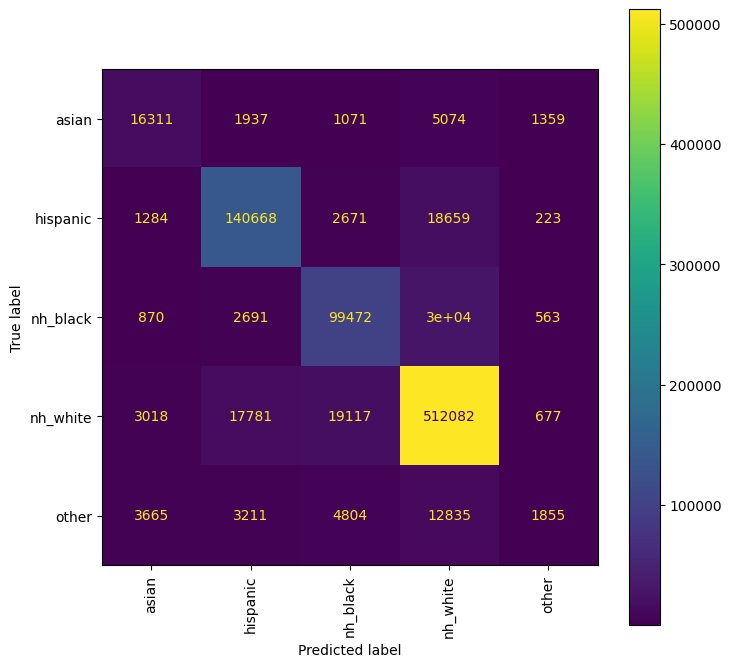

In [78]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

rnn.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = test_rnn(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

import matplotlib.pyplot as plt
%matplotlib inline

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

In [80]:
!du -sh lstm_FullName_pytorch.pt

4.1M	lstm_FullName_pytorch.pt
